# Training a simple single layer Neural network with DFA



Work from Anas. Served as a basis for my own code

### useful imports

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Define NN structure

In [9]:
# Define the network architecture with a hidden layer and Tanh activation
class SimpleDFA(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        super(SimpleDFA, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input weight matrix (input to hidden)
        self.fc2 = nn.Linear(hidden_size, output_size)  # Output weight matrix (hidden to output)
        self.activation = nn.Tanh()  # Use Tanh activation function

    def forward(self, x):
        
        x = self.activation(self.fc1(x))  # Hidden layer with Tanh activation
        return self.activation(self.fc2(x))  # Output layer with Tanh activation
    
    
    def Init_weights(self):
        # Xavier init on weights
        nn.init.xavier_uniform_(self.fc1.weight) 
        nn.init.xavier_uniform_(self.fc2.weight) 

        print(self.fc1.weight)
        print(self.fc2.weight)
        
    
    def Init_feedback(self):
        
        self.B_1 = torch.randn(self.output_size, self.output_size) * 0.01  # Feedback for 1st layer
        self.B_2 = torch.randn(self.hidden_size, self.output_size) * 0.01 # Feedback for 2nd layer
        
        #normalize the feedback matrices to avoid exploding feedback
        self.B_1 = self.B_1 / self.B_1.norm()
        self.B_2 = self.B_2 / self.B_2.norm()
        return self.B_1, self.B_2
    
    def forward_pass(self,Input,Target,loss_func):
        
        # Forward pass
        Output = self.forward(Input)
        loss = loss_func(Output, Target)
        return Output, loss
        
    def activation_derivative(self, x):
        
        return 1 - self.activation(x)**2  # Derivative of Tanh activation function
    
    
def dfa_update_step(model, feedback_matrix_output, feedback_matrix_input, output, target, hidden_activations, inputs, learning_rate=0.01):
    #function to update the weights and biases using DFA
    error = output - target  # Compute error
    
    # update the output weights and biases at the output
    feedback_signal_output = torch.matmul(error * model.activation_derivative(output), feedback_matrix_output)
    
    with torch.no_grad():
        #weight update for the output layer
        delta_w_out = torch.matmul(feedback_signal_output.T, hidden_activations)
        model.fc2.weight -= learning_rate * delta_w_out
        #bias update for the output layer
        delta_b_out = feedback_signal_output.sum(0)
        model.fc2.bias -= learning_rate * delta_b_out
        
    # update the input to hidden weights and biases
    feedback_signal_input = torch.matmul(error * model.activation_derivative(hidden_activations), feedback_matrix_input)
    
    with torch.no_grad():
        #weight update for the input layer
        delta_w_in = torch.matmul(feedback_signal_input.T, inputs)
        model.fc1.weight -= learning_rate * delta_w_in
        #bias update for the input layer
        delta_b_in = feedback_signal_input.sum(0)
        model.fc1.bias -= learning_rate * delta_b_in
        
        
def fa_update_step(model, feedback_matrix_output, feedback_matrix_input, output, target, hidden_activations, inputs, learning_rate=0.01):
    #function to update the weights and biases using simple FA
    error = output - target  # Compute error
    
    # update the output weights and biases at the output
    feedback_signal_output = torch.matmul(error * model.activation_derivative(output), feedback_matrix_output)
    
    with torch.no_grad():
        #weight update for the output layer
        delta_w_out = torch.matmul(feedback_signal_output.T, hidden_activations)
        model.fc2.weight -= learning_rate * delta_w_out
        #bias update for the output layer
        delta_b_out = feedback_signal_output.sum(0)
        model.fc2.bias -= learning_rate * delta_b_out
        
    # update the input to hidden weights and biases
    feedback_signal_input = torch.matmul(error * model.activation_derivative(hidden_activations), feedback_matrix_input)
    
    with torch.no_grad():
        #weight update for the input layer
        delta_w_in = torch.matmul(feedback_signal_input.T, inputs)
        model.fc1.weight -= learning_rate * delta_w_in
        #bias update for the input layer
        delta_b_in = feedback_signal_input.sum(0)
        model.fc1.bias -= learning_rate * delta_b_in
        
    
    

### Define training loop funciton

In [10]:
def train(model, data, targets, loss_fn, learning_rate=0.01, epochs=1000):
    # Initialize feedback matrices
    B_1, B_2 = model.Init_feedback()

    losses = []  # To store the loss at each epoch
    for epoch in range(epochs):
        # Forward pass
        hidden_activations = model.activation(model.fc1(data))  # Get hidden layer activations
        output, loss = model.forward_pass(data, targets, loss_fn)

        # Apply DFA update step
        dfa_update_step(model, B_1, B_2, output, targets, hidden_activations, data, learning_rate)

        # Store the loss
        losses.append(loss.item())

        # Print loss and accuracy every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item()}")

            # Compute accuracy
            predictions = (output >= 0.5).float()  # Threshold the output to get binary predictions
            correct = (predictions == targets).float().sum()
            accuracy = correct / targets.size(0)
            print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Plot the convergence of loss
    plt.plot(losses)
    plt.title("Convergence of Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


#### Trying the code on a simple XOR task

Parameter containing:
tensor([[-0.6569,  0.3370],
        [ 0.2458,  0.6639],
        [-0.0929,  0.7401],
        [-0.6209, -0.3832]], requires_grad=True)
Parameter containing:
tensor([[ 1.0679, -0.9307,  0.4411,  0.1244]], requires_grad=True)
Epoch [0/1000], Loss: 1.212409496307373
Accuracy: 50.00%
Epoch [100/1000], Loss: 0.19499054551124573
Accuracy: 75.00%
Epoch [200/1000], Loss: 0.19867099821567535
Accuracy: 75.00%
Epoch [300/1000], Loss: 0.20803683996200562
Accuracy: 50.00%
Epoch [400/1000], Loss: 0.2124108523130417
Accuracy: 50.00%
Epoch [500/1000], Loss: 0.2156759798526764
Accuracy: 50.00%
Epoch [600/1000], Loss: 0.21885937452316284
Accuracy: 50.00%
Epoch [700/1000], Loss: 0.2219373881816864
Accuracy: 50.00%
Epoch [800/1000], Loss: 0.22481510043144226
Accuracy: 50.00%
Epoch [900/1000], Loss: 0.22743085026741028
Accuracy: 75.00%


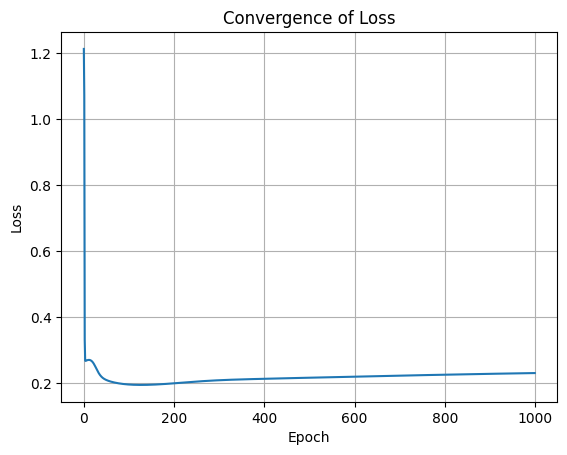

In [11]:
# # Example usage with XOR data
# input_size = 2  # XOR has two input features (0 or 1)
# hidden_size = 4  # You can adjust this value for the hidden layer
# output_size = 1  # XOR has one output feature (0 or 1)

# # Define XOR inputs and targets
# data = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)  # XOR inputs
# targets = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)  # XOR targets


# Example usage with XOR data
input_size = 3  # XOR has two input features (0 or 1)
hidden_size = 4  # You can adjust this value for the hidden layer
output_size = 2  # XOR has one output feature (0 or 1)


data = torch.tensor([[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0]], dtype=torch.float32)  # XOR inputs
targets = torch.tensor([[0, 0], [1, 0], [1, 0], [0, 0]], dtype=torch.float32)  # XOR targets



# Initialize the model and loss function
model = SimpleDFA(input_size, hidden_size, output_size)
model.Init_weights()  # Initialize the weights

loss_fn = nn.MSELoss()  

# Train the network using DFA and print XOR accuracy
train(model, data, targets, loss_fn, learning_rate=0.1, epochs=1000)
